# 1. Loading Data
os library only imported to find the current working folder to relocate the DB file.
SQLalchemy is imported to make SQL queries from the database containing the simulation results.
We are also importing Pandas to read the result of SQL queries into Dataframes for further analysis.

In [1]:
import os 
import pandas as pd
from sqlalchemy import create_engine

The results database that we are going to read and analyze data from is created by the other project in my account: [Feeder Power Loss Simulation](https://github.com/pooya-bagheri/Feeder-PowerLoss-Simulation)

In [2]:
DBfilePath=os.path.abspath('')+'//'+'SimResultsIEEE123NodesCase2.db'
DB = create_engine('sqlite:///'+DBfilePath, echo=False)   

Database includes data for 30 simulated days. We don't want to explode the memory.So, Let's just focus on the first day read first day's Ploss data and voltages for one node:

In [3]:
Ploss=pd.read_sql_query('Select * from Losses',con=DB)
Ploss.head()

,InstantID,Ploss
0,1,25.598380
1,2,25.351119
2,3,25.104456
3,4,24.859135
4,5,24.615373


In [4]:
Ploss=pd.read_sql_query('''
select Instants.InstantID,Losses.Ploss
from Instants join Losses on Instants.InstantID=Losses.InstantID
where Instants.Day==1''',con=DB)
Ploss.head()
Ploss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 2 columns):
InstantID    1440 non-null int64
Ploss        1440 non-null float64
dtypes: float64(1), int64(1)
memory usage: 22.6 KB


In [5]:
RawVoltages=pd.read_sql_query('''
select Instants.InstantID,Voltages.NodeID,Voltages.Vmag
from Instants join Voltages on Instants.InstantID=Voltages.InstantID
where Instants.Day==1''',con=DB)
RawVoltages.head()

,InstantID,NodeID,Vmag
0,1,1,1.0000
1,1,2,1.0125
2,1,3,1.0125
3,1,4,1.0069
4,1,5,1.0132


We can see that voltages of all node are present here. Let's group voltage measurements to get the average by every node.

In [6]:
VoltagesMean=pd.read_sql_query('''
select Instants.InstantID,avg(Voltages.Vmag) as Vmean
from Instants join Voltages on Instants.InstantID=Voltages.InstantID
where Instants.Day==1
group by Instants.InstantID''',con=DB)
VoltagesMean.head()

,InstantID,Vmean
0,1,1.013455
1,2,1.013608
2,3,1.013768
3,4,1.013920
4,5,1.014074


Let's have a look at what we have collected so far. We import from matplotlib for this purpose:

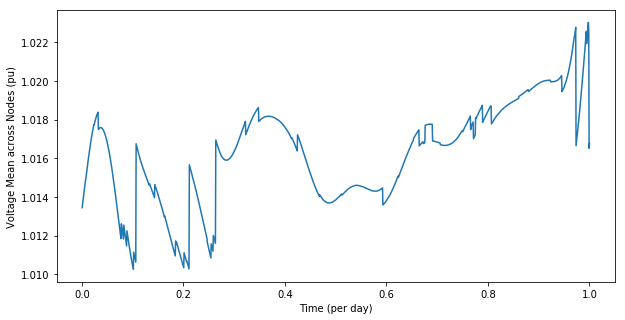

In [23]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5] #making the plots a bit larger than default size
Time=VoltagesMean['InstantID']/max(VoltagesMean['InstantID'])
Vmean=VoltagesMean['Vmean']
plt.plot(Time,Vmean)
plt.xlabel('Time (per day)')
plt.ylabel('Voltage Mean across Nodes (pu)')
plt.show()

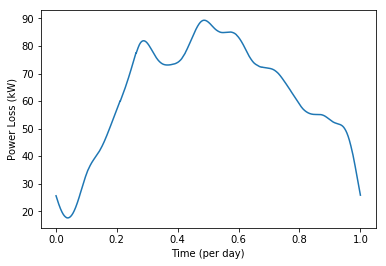

In [8]:
plt.plot(Time,Ploss['Ploss'])
plt.xlabel('Time (per day)')
plt.ylabel('Power Loss (kW)')
plt.show()

# 2. Relationship between Voltages and Power Loss
We are interested to learn about relationship of voltages and losses. As we can see in the last two graphs, there is no observable correlation between mean of voltage and losses, we need to look further. Let's do a pivot opearation in pandas to get all node voltages for each instant:

In [9]:
Voltages=RawVoltages.pivot(index='InstantID', columns='NodeID', values='Vmag')
Voltages.head()

NodeID,1,2,3,4,5,6,7,8,9,10,...,269,270,271,272,273,274,275,276,277,278
InstantID,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0125,1.0125,1.0069,1.0132,1.0081,1.0028,1.0076,1.0073,1.0068,...,1.0282,1.0282,1.0282,1.0011,1.0044,1.0284,1.0033,1.0033,1.0004,1.0088
2,1.0,1.0125,1.0125,1.0070,1.0132,1.0081,1.0029,1.0077,1.0073,1.0069,...,1.0284,1.0284,1.0284,1.0012,1.0045,1.0286,1.0035,1.0035,1.0005,1.0090
3,1.0,1.0125,1.0125,1.0070,1.0132,1.0081,1.0030,1.0077,1.0074,1.0069,...,1.0286,1.0286,1.0286,1.0013,1.0046,1.0288,1.0037,1.0037,1.0006,1.0092
4,1.0,1.0125,1.0125,1.0071,1.0132,1.0081,1.0031,1.0077,1.0074,1.0069,...,1.0288,1.0288,1.0288,1.0014,1.0047,1.0289,1.0038,1.0038,1.0007,1.0093
5,1.0,1.0125,1.0125,1.0071,1.0133,1.0082,1.0031,1.0077,1.0074,1.0070,...,1.0290,1.0289,1.0289,1.0015,1.0047,1.0291,1.0040,1.0040,1.0009,1.0095


Using this pivoted table, let's have a look on plot of voltage std:

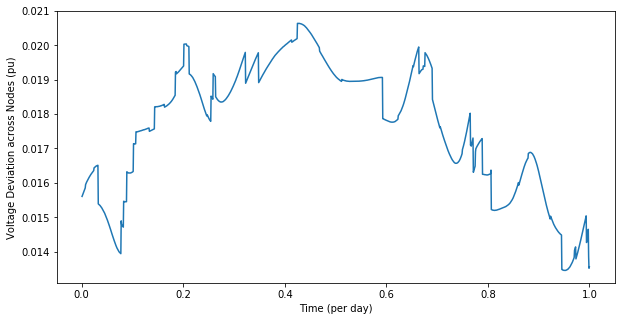

In [21]:
Vstd=Voltages.std(axis=1)
plt.plot(Time,Vstd)
plt.xlabel('Time (per day)')
plt.ylabel('Voltage Deviation across Nodes (pu)')
plt.show()

Compared to voltages mean, we can see that voltage deviations have much better correlation with losses. This can be also observed by the following scatter plots:

Text(0, 0.5, 'Power Loss (kW)')

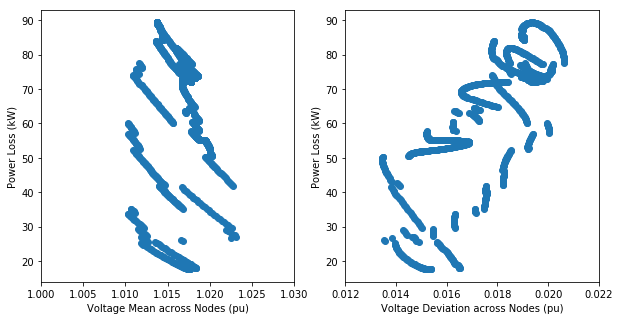

In [24]:
plt.subplot(121)
plt.scatter(Vmean,Ploss['Ploss'])
plt.gca().set_xlim([1,1.03])
plt.xlabel('Voltage Mean across Nodes (pu)')
plt.ylabel('Power Loss (kW)')
plt.subplot(122)
plt.scatter(Vstd,Ploss['Ploss'])
plt.gca().set_xlim([0.012,0.022])
plt.xlabel('Voltage Deviation across Nodes (pu)')
plt.ylabel('Power Loss (kW)')

Also, we can verify it by looking at correlation of these:

In [30]:
print("""Correlation Coefficients
Ploss and Voltage Mean: %.2f
Ploss and Voltage Deviation: %.2f""" % (pd.Series.corr(Vmean,Ploss['Ploss']),pd.Series.corr(Vstd,Ploss['Ploss'])))

Correlation Coefficients
Ploss and Voltage Mean: -0.13
Ploss and Voltage Deviation: 0.73


This observation is also consistent with what we know from power circuit theories. The more voltages of nodes be deviated from each other, the more currents flow in powerlines causing a total higher power loss.

# 3.Dimension Reduction: PCA
So far, we have only looked at Mean and Std of voltages across system to investigate relationship between voltages and power loss. What other aspects of the data we can use for this investigation? We have already seen that 277 nodes are present in the simulated system. It's too hard to study relationship of voltage at each of these nodes to the power loss. 
A possible solution is using a dimension reduction technique such as Principal Component Analysis (PCA). Such methods can give us the main components of variation from voltage data, and then we will compare those to power loss: